<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 LD-PLSM Modeling and Comaprison with & without Environmental Parameters
</p>

In [2]:
import numpy as np                                           # For numerical operations
import pandas as pd                                          # For data manipulation and analysis
import matplotlib.pyplot as plt                              # For plotting and visualizations
import matplotlib.dates as mdates                            # For handling date formatting in plots
import seaborn as sns                                        # For enhanced data visualizations
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import MaxNLocator  # Import MaxNLocator for controlling y-axis ticks
from sklearn.metrics import mean_squared_error, r2_score     # For model evaluation metrics
from sklearn.model_selection import KFold, train_test_split  # For splitting data and cross-validation
from scipy.optimize import curve_fit                         # For curve fitting and optimization                       # For formula-based statistical modeling

In [3]:
# Load the cleaned data by IF into 'df' and display it.
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874160 entries, 0 to 874159
Data columns (total 20 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   time         874160 non-null  object 
 1   device_id    874160 non-null  object 
 2   co2          874160 non-null  float64
 3   humidity     874160 non-null  float64
 4   pm25         874160 non-null  float64
 5   pressure     874160 non-null  float64
 6   temperature  874160 non-null  float64
 7   rssi         874160 non-null  float64
 8   snr          874160 non-null  float64
 9   SF           874160 non-null  int64  
 10  frequency    874160 non-null  float64
 11  f_count      874160 non-null  float64
 12  p_count      874160 non-null  float64
 13  toa          874160 non-null  float64
 14  distance     874160 non-null  int64  
 15  c_walls      874160 non-null  int64  
 16  w_walls      874160 non-null  int64  
 17  exp_pl       874160 non-null  float64
 18  n_power      874160 non-

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Data Preparation and Single Train-Test Split
</p>

In [5]:
# Extract the device_id column
device_id_all = df['device_id'].values

# Existing features and target
all_features = np.column_stack((
    df['distance'].values, 
    df['frequency'].values, 
    df['c_walls'].values, 
    df['w_walls'].values, 
    df['co2'].values, 
    df['humidity'].values,
    df['pm25'].values, 
    df['pressure'].values, 
    df['temperature'].values, 
    df['snr'].values
))
PL_all = df['exp_pl'].values
time_all = df['time'].values
indices = np.arange(len(df))

# Use stratify to ensure the distribution of device IDs is preserved.
X_train_all, X_test_all, PL_train_all, PL_test_all, time_train, time_test, train_idx, test_idx = train_test_split(
    all_features,
    PL_all,
    time_all,
    indices,
    test_size=0.2,
    random_state=200,
    shuffle=True,
    stratify=device_id_all  # To ensure each device is represented in both splits.
)

# Sort the training set by time and overwrite the original variable names:
order_train = np.argsort(time_train)
time_train   = time_train[order_train]
X_train_all  = X_train_all[order_train]
PL_train_all = PL_train_all[order_train]
train_idx    = train_idx[order_train]

# Sort the test set by time and overwrite the original variable names:
order_test = np.argsort(time_test)
time_test   = time_test[order_test]
X_test_all  = X_test_all[order_test]
PL_test_all = PL_test_all[order_test]
test_idx    = test_idx[order_test]

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Analyzing Temporal Distribution in Training and Testing Sets
</p>

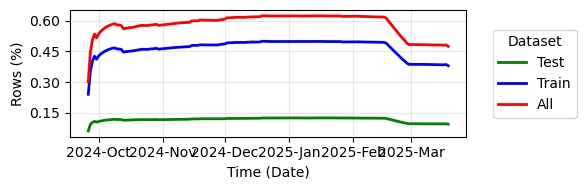

In [7]:
# Convert timestamp to datetime with explicit ISO8601 format
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# Reuse the same train/test indices
train_indices = train_idx
test_indices  = test_idx

def calculate_percentage(indices, total_len, window=50):
    # Group by date using the 'time' column and count records
    daily_counts = df.iloc[indices].groupby(df.iloc[indices]['time'].dt.date).size()
    # Convert to percentage
    percentages = (daily_counts / total_len * 100).rename_axis('date')
    # Reindex to ensure continuity across dates and apply rolling mean
    full_range = pd.date_range(start=percentages.index.min(), end=percentages.index.max())
    return (percentages.reindex(full_range, fill_value=0)
                       .sort_index()
                       .rolling(window, min_periods=1)
                       .mean())

total_len = len(df)
train_percentages = calculate_percentage(train_indices, total_len)
test_percentages  = calculate_percentage(test_indices, total_len)
whole_percentages = calculate_percentage(indices, total_len)

fig, ax = plt.subplots(figsize=(6, 2))
ax.grid(True, alpha=0.3)

for data, color, label in [(test_percentages, 'green', 'Test'),
                           (train_percentages, 'blue', 'Train'),
                           (whole_percentages, 'red', 'All')]:
    ax.plot(data.index, data.values, color=color, label=label, linewidth=2)

ax.set(xlabel='Time (Date)', ylabel='Rows (%)')

# Adjust the legend position to the right of the plot
ax.legend(title='Dataset', bbox_to_anchor=(1.05, 0.9), loc='upper left')

# Adjust x-axis formatting with year in front of the month
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%b'))

ax.tick_params(direction='out')  # outward ticks

# Adjust the y-axis ticks to include more scale values
ax.yaxis.set_major_locator(MaxNLocator(nbins=5, prune=None)) 

plt.tight_layout()

# Save the figure to the specified directory with 1000 dpi
plt.savefig('../all_data_files/Observations_Over_Time.png', dpi=1000)

plt.show()

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Defining LDPLM-MW Model, Fitting, and Extracting Parameters
</p>

In [9]:
# Indices for features used in LDPLM-MW
idx_mw = [0, 2, 3]  # Indices of d_all, c_walls_all, w_walls_all in all_features

# Extract training and testing data for LDPLM-MW
x_train_mw = X_train_all[:, idx_mw].T  # Transpose to match original shape
x_test_mw = X_test_all[:, idx_mw].T
PL_train_mw = PL_train_all
PL_test_mw = PL_test_all

# Define the Log-Distance Path Loss Model with Multi-Wall alone
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1  # Reference distance in meters
    return (PL_d0 + 10 * n * np.log10(d / d0) + c_walls * L_c + w_walls * L_w)

# Initial guesses for PL_d0, n, L_c, and L_w
initial_guesses_mw = [30, 2, 5, 3]  # Can be adjusted

# Perform curve fitting for LDPLM-MW
popt_mw, pcov_mw = curve_fit(
    log_distance_path_loss_separate_walls,
    x_train_mw,
    PL_train_mw,
    p0=initial_guesses_mw,
    maxfev=100000
)

# Extract the fitted parameters for LDPLM-MW
PL_d0_mw, n_mw, L_c_mw, L_w_mw = popt_mw

# Predict path loss for the test set
PL_pred_mw = log_distance_path_loss_separate_walls(x_test_mw, PL_d0_mw, n_mw, L_c_mw, L_w_mw)

# Calculate the shadowing component for the training set
PL_train_pred_mw = log_distance_path_loss_separate_walls(x_train_mw, PL_d0_mw, n_mw, L_c_mw, L_w_mw)
shadowing_train_mw = PL_train_mw - PL_train_pred_mw
sigma_mw = np.std(shadowing_train_mw)

# Calculate RMSE and R-squared for LDPLM-MW on Test Set
rmse_mw = np.sqrt(mean_squared_error(PL_test_mw, PL_pred_mw))
r_squared_mw = r2_score(PL_test_mw, PL_pred_mw)

# Calculate RMSE and R-squared for LDPLM-MW on Training Set
rmse_train_mw = np.sqrt(mean_squared_error(PL_train_mw, PL_train_pred_mw))
r_squared_train_mw = r2_score(PL_train_mw, PL_train_pred_mw)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Defining LDPLM-MW-EP Model, Fitting, and Extracting Parameters
</p>

In [11]:
# Indices for features used in LDPLM-MW-EP
idx_ep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Extract training and testing data for LDPLM-MW-EP
x_train_ep = X_train_all[:, idx_ep].T
x_test_ep = X_test_all[:, idx_ep].T
PL_train_ep = PL_train_all
PL_test_ep = PL_test_all

# Define the enhanced Log-Distance Path Loss Model with Environmental Parameters
def log_distance_path_loss_with_env_params(x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr):
    d, frequency, c_walls, w_walls, co2, humidity, pm25, pressure, temperature, snr = x
    d0 = 1  # Reference distance in meters
    return (PL_d0 + 10 * n * np.log10(d / d0) + 20 * np.log10(frequency) + c_walls * L_c + w_walls * L_w +
            a_co2 * co2 + a_hum * humidity + a_pm25 * pm25 +
            a_pres * pressure + a_temp * temperature + snr * k_snr)

# Initial guesses for PL_d0, n, L_c, L_w, environmental factors, and SNR coefficient
initial_guesses_ep = [30, 2, 5, 3, 0.01, 0.01, 0.01, 0.01, 0.01, 1]  # Can be adjusted

# Perform curve fitting for LDPLM-MW-EP
popt_ep, pcov_ep = curve_fit(
    log_distance_path_loss_with_env_params,
    x_train_ep,
    PL_train_ep,
    p0=initial_guesses_ep,
    maxfev=100000
)

# Extract the fitted parameters for LDPLM-MW-EP
PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep = popt_ep

# Predict path loss for the test set
PL_pred_ep = log_distance_path_loss_with_env_params(
    x_test_ep, PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep
)

# Calculate the shadowing component for the training set
PL_train_pred_ep = log_distance_path_loss_with_env_params(
    x_train_ep, PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep
)
shadowing_train_ep = PL_train_ep - PL_train_pred_ep
sigma_ep = np.std(shadowing_train_ep)

# Calculate RMSE and R-squared for LDPLM-MW-EP on Test Set
rmse_ep = np.sqrt(mean_squared_error(PL_test_ep, PL_pred_ep))
r_squared_ep = r2_score(PL_test_ep, PL_pred_ep)

# Calculate RMSE and R-squared for LDPLM-MW-EP on Training Set
rmse_train_ep = np.sqrt(mean_squared_error(PL_train_ep, PL_train_pred_ep))
r_squared_train_ep = r2_score(PL_train_ep, PL_train_pred_ep)

<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Comparing Parameters and Metrics for the two Models
</p>

In [13]:
# Parameters Comparison
params_mw = {
    'PL(d0) [dB]': PL_d0_mw,
    'Path loss exponent (n)': n_mw,
    'Brick Wall Loss (L_c) [dB]': L_c_mw,
    'Wood Wall Loss (L_w) [dB]': L_w_mw
}

params_ep = {
    'PL(d0) [dB]': PL_d0_ep,
    'Path loss exponent (n)': n_ep,
    'Brick Wall Loss (L_c) [dB]': L_c_ep,
    'Wood Wall Loss (L_w) [dB]': L_w_ep,
    'CO2 coefficient (a_co2) [dB/unit]': a_co2_ep,
    'Humidity coefficient (a_hum) [dB/unit]': a_hum_ep,
    'PM2.5 coefficient (a_pm25) [dB/unit]': a_pm25_ep,
    'Pressure coefficient (a_pres) [dB/unit]': a_pres_ep,
    'Temperature coefficient (a_temp) [dB/unit]': a_temp_ep,
    'SNR scaling factor (k_snr)': k_snr_ep
}

# Define the list of shared and unique parameters
shared_params = ['PL(d0) [dB]', 'Path loss exponent (n)', 'Brick Wall Loss (L_c) [dB]', 'Wood Wall Loss (L_w) [dB]']
unique_params_ep = [
    'CO2 coefficient (a_co2) [dB/unit]', 
    'Humidity coefficient (a_hum) [dB/unit]', 
    'PM2.5 coefficient (a_pm25) [dB/unit]', 
    'Pressure coefficient (a_pres) [dB/unit]', 
    'Temperature coefficient (a_temp) [dB/unit]', 
    'SNR scaling factor (k_snr)'
]

# Create the Parameter list: shared parameters + unique EP parameters
parameter_list = shared_params + unique_params_ep  # Total 10 parameters

# Create the LDPLM-MW column: shared parameters' values + '-' for unique EP parameters
ldplm_mw_values = [params_mw[param] for param in shared_params] + ['-' for _ in unique_params_ep]

# Create the LDPLM-MW-EP column: shared parameters' values + unique EP parameters' values
ldplm_ep_values = [params_ep[param] for param in shared_params] + [params_ep[param] for param in unique_params_ep]

# Construct the DataFrame
params_df = pd.DataFrame({
    'Parameter': parameter_list,
    'LDPLM-MW': ldplm_mw_values,
    'LDPLM-MW-EP': ldplm_ep_values
})

print("\n=== Table of Parameters to be Compared ===\n")
display(params_df)

# Metrics Comparison Including Training and Test Sets 
# Metrics Comparison
metrics = [
    'RMSE (Train) [dB]', 
    'RMSE (Test) [dB]', 
    'R-squared (Train)', 
    'R-squared (Test)', 
    'Shadowing σ (dB)'
]
metrics_values = {
    'LDPLM-MW': [rmse_train_mw, rmse_mw, r_squared_train_mw, r_squared_mw, sigma_mw],
    'LDPLM-MW-EP': [rmse_train_ep, rmse_ep, r_squared_train_ep, r_squared_ep, sigma_ep]
}

metrics_df = pd.DataFrame(metrics_values, index=metrics)

print("\n=== Performance Metrics Comparison ===\n")
display(metrics_df)


=== Table of Parameters to be Compared ===



,Parameter,LDPLM-MW,LDPLM-MW-EP
0,PL(d0) [dB],29.080798,3.195465
1,Path loss exponent (n),3.844346,3.403307
2,Brick Wall Loss (L_c) [dB],9.429503,8.136433
3,Wood Wall Loss (L_w) [dB],2.408446,2.771063
4,CO2 coefficient (a_co2) [dB/unit],-,-0.002554
5,Humidity coefficient (a_hum) [dB/unit],-,-0.064246
6,PM2.5 coefficient (a_pm25) [dB/unit],-,-0.136674
7,Pressure coefficient (a_pres) [dB/unit],-,-0.010938
8,Temperature coefficient (a_temp) [dB/unit],-,-0.017518
9,SNR scaling factor (k_snr),-,-1.984571



=== Performance Metrics Comparison ===



,LDPLM-MW,LDPLM-MW-EP
RMSE (Train) [dB],10.556703,8.008010
RMSE (Test) [dB],10.606830,8.036909
R-squared (Train),0.696450,0.825328
R-squared (Test),0.693389,0.823967
Shadowing σ (dB),10.556703,8.008010


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Plotting some comparison Parameters and Metrics for the two Models
</p>

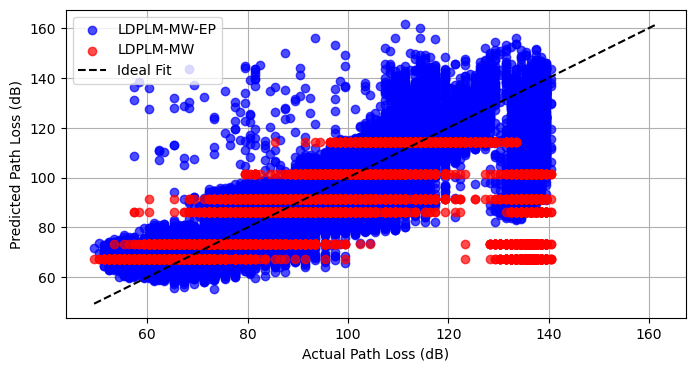

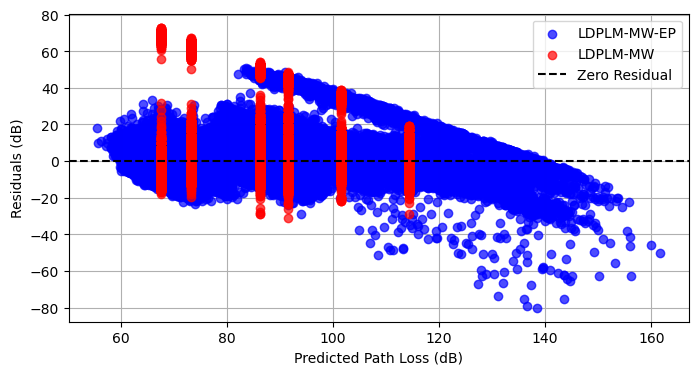

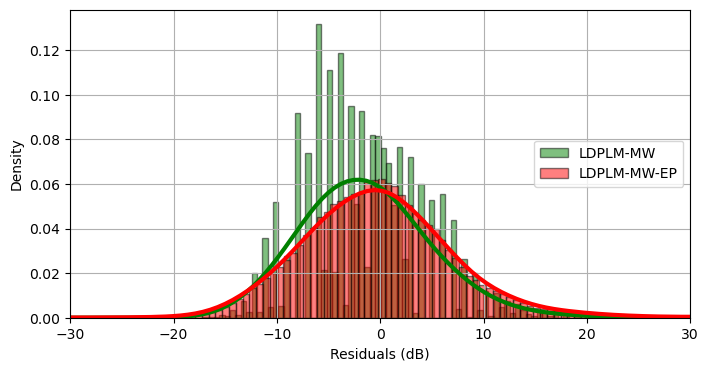


Residual Distribution Values:

LDPLM-MW: Mean: 0.0139 dB, Skewness: 3.7744
LDPLM-MW-EP: Mean: 0.0226 dB, Skewness: 1.0472


In [15]:
# -------------------------------
# Section 4: 
# -------------------------------

# Step 15: Plot Actual vs Predicted Path Loss
plt.figure(figsize=(8, 4))
# Plot LDPLM-MW-EP first in blue
plt.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW last in red to appear in foreground
plt.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Ideal Fit Line in black, highest zorder to appear on top
min_PL = min(PL_test_mw.min(), PL_test_ep.min(), PL_pred_mw.min(), PL_pred_ep.min())
max_PL = max(PL_test_mw.max(), PL_test_ep.max(), PL_pred_mw.max(), PL_pred_ep.max())
plt.plot(
    [min_PL, max_PL],
    [min_PL, max_PL],
    'k--', label='Ideal Fit', zorder=4
)
plt.xlabel('Actual Path Loss (dB)')
plt.ylabel('Predicted Path Loss (dB)')
# plt.title('Actual vs Predicted Path Loss Comparison')
plt.legend(loc='upper left')
plt.grid(True)
plt.savefig('../all_data_files/Actual_vs_Predicted.png', dpi=1000)
plt.show()

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss
residuals_mw = PL_test_mw - PL_pred_mw
residuals_ep = PL_test_ep - PL_pred_ep

plt.figure(figsize=(8, 4))
# Plot LDPLM-MW-EP residuals first in blue
plt.scatter(PL_pred_ep, residuals_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW residuals last in red to appear in foreground
plt.scatter(PL_pred_mw, residuals_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Horizontal line at zero in black, highest zorder to appear on top
plt.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
plt.xlabel('Predicted Path Loss (dB)')
plt.ylabel('Residuals (dB)')
# plt.title('Residuals vs Predicted Path Loss Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('../all_data_files/Residuals_vs_Predicted.png', dpi=1000)
plt.show()

# Step 17: Residual Analysis - Histogram of Residuals with KDE and Smoothness Control
plt.figure(figsize=(8, 4))

# Plot histograms with density=True to normalize the counts
plt.hist(residuals_mw, bins=200, alpha=0.5, label='LDPLM-MW', color='green', edgecolor='k', density=True)
plt.hist(residuals_ep, bins=200, alpha=0.5, label='LDPLM-MW-EP', color='red', edgecolor='k', density=True)

# KDE plots using Seaborn 
sns.kdeplot(residuals_mw, color='green', bw_adjust=3, linewidth=3)
sns.kdeplot(residuals_ep, color='red', bw_adjust=3, linewidth=3)

plt.xlabel('Residuals (dB)')
plt.ylabel('Density')  # Changed from 'Frequency' to 'Density' due to normalization
# plt.title('Histogram of Residuals Comparison')
plt.xlim(-30, 30)  # Set x-axis limits
plt.legend(loc='center right')
plt.grid(True)
plt.savefig('../all_data_files/Histogram_of_Residuals_with_KDE.png', dpi=1000)
plt.show()

# Convert numpy arrays to pandas Series
residuals_mw = pd.Series(residuals_mw)
residuals_ep = pd.Series(residuals_ep)

# Residual Distribution Values
resid_mean_mw = round(residuals_mw.mean(), 4)
resid_skew_mw = round(residuals_mw.skew(), 4)

resid_mean_ep = round(residuals_ep.mean(), 4)
resid_skew_ep = round(residuals_ep.skew(), 4)

print(f'\nResidual Distribution Values:')
print(f'\nLDPLM-MW: Mean: {resid_mean_mw} dB, Skewness: {resid_skew_mw}')
print(f'LDPLM-MW-EP: Mean: {resid_mean_ep} dB, Skewness: {resid_skew_ep}')


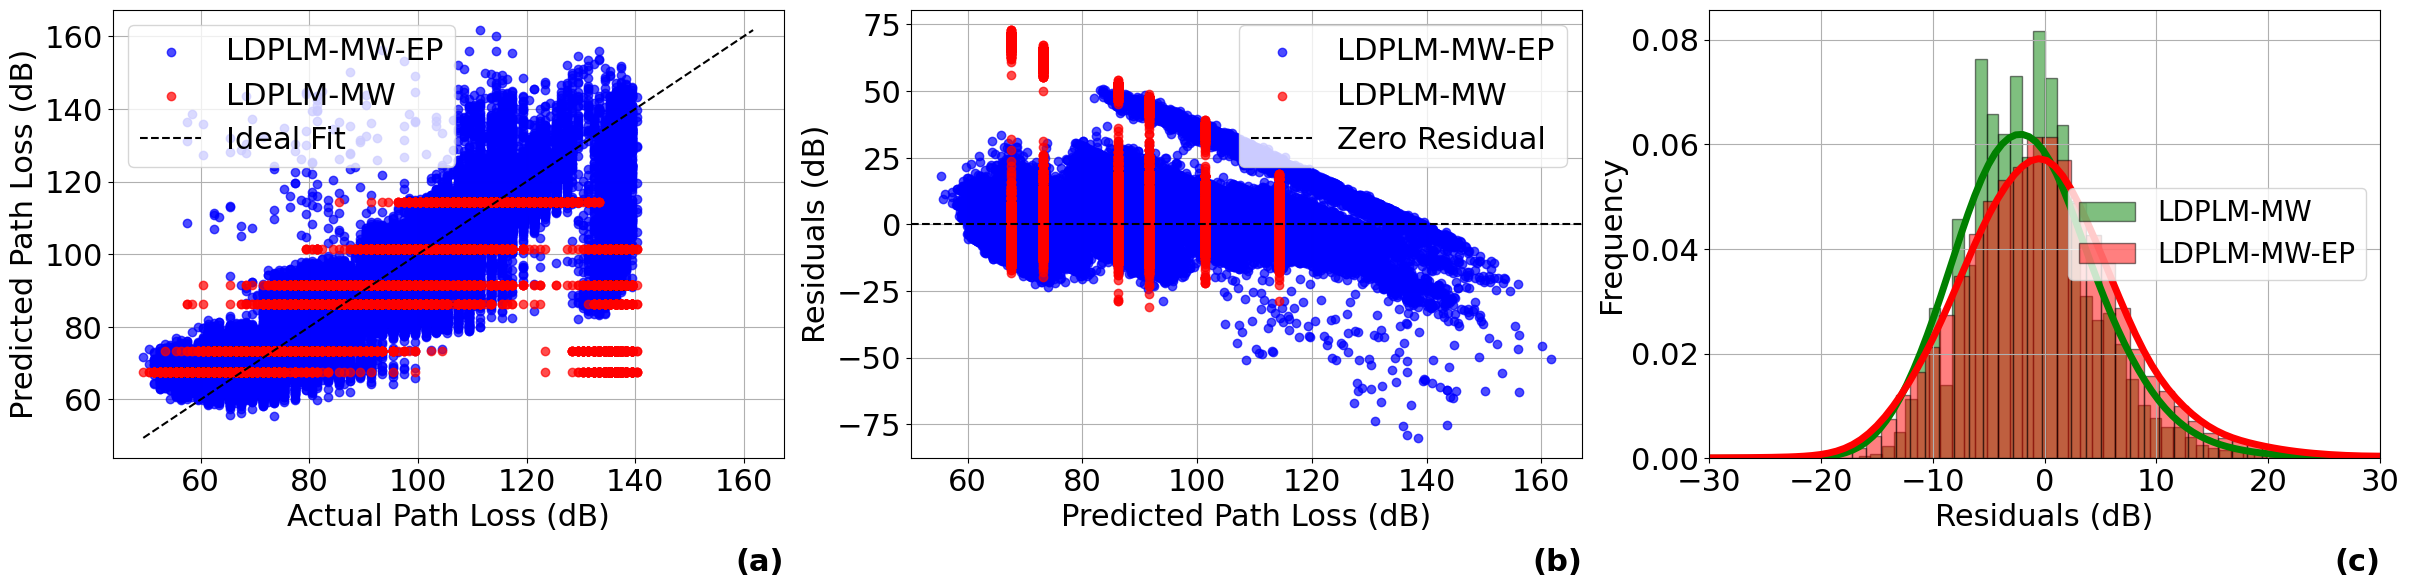


Residual Distribution Values:

LDPLM-MW: Mean: 0.0139 dB, Skewness: 3.7744
LDPLM-MW-EP: Mean: 0.0226 dB, Skewness: 1.0472


In [16]:
# -------------------------------
# Section 4: Plotting
# -------------------------------

# Step 15, 16 & 17: Plot Actual vs Predicted Path Loss, Residual Analysis, and Histogram as Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Step 15: Plot Actual vs Predicted Path Loss on ax1
# Plot LDPLM-MW-EP first in blue
ax1.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW last in red to appear in foreground
ax1.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Ideal Fit Line in black, highest zorder to appear on top
ax1.plot(
    [min_PL, max_PL],
    [min_PL, max_PL],
    'k--', label='Ideal Fit', zorder=4
)
ax1.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax1.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
# ax1.set_title('Actual vs Predicted Path Loss Comparison')
ax1.legend(fontsize=22, loc='upper left')
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=22)
ax1.text(1, -0.2, '(a)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss on ax2
# Plot LDPLM-MW-EP residuals first in blue
ax2.scatter(PL_pred_ep, residuals_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW residuals last in red to appear in foreground
ax2.scatter(PL_pred_mw, residuals_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Horizontal line at zero in black, highest zorder to appear on top
ax2.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax2.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax2.set_ylabel('Residuals (dB)', fontsize=22)
# ax2.set_title('Residuals vs Predicted Path Loss Comparison')
ax2.legend(fontsize=22, loc='upper right')
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=22)
ax2.text(1, -0.2, '(b)', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 17: Residual Analysis - Histogram of Residuals on ax3
# Plot histogram for LDPLM-MW
ax3.hist(residuals_mw, bins=100, alpha=0.5, label='LDPLM-MW', color='green', edgecolor='k', density=True)
# Plot histogram for LDPLM-MW-EP with density normalization
ax3.hist(residuals_ep, bins=100, alpha=0.5, label='LDPLM-MW-EP', color='red', edgecolor='k', density=True)
# KDE plots using Seaborn 
sns.kdeplot(residuals_mw, color='green', bw_adjust=3, ax=ax3, linewidth=5)
sns.kdeplot(residuals_ep, color='red', bw_adjust=3, ax=ax3, linewidth=5)

ax3.set_xlabel('Residuals (dB)', fontsize=22)
ax3.set_ylabel('Frequency', fontsize=22)
# ax3.set_title('Histogram of Residuals Comparison')
ax3.set_xlim(-30, 30)  # Set x-axis limits
ax3.legend(fontsize=20, loc='center right')
ax3.grid(True)
ax3.tick_params(axis='both', which='major', labelsize=22)
ax3.text(1, -0.2, '(c)', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()
# Save the combined figure
plt.savefig('../all_data_files/All_Plots_as_Subplots.png', dpi=1000)
plt.show()

# Residual Distribution Values
resid_mean_mw = round(residuals_mw.mean(), 4)
resid_skew_mw = round(residuals_mw.skew(), 4)

resid_mean_ep = round(residuals_ep.mean(), 4)
resid_skew_ep = round(residuals_ep.skew(), 4)

print(f'\nResidual Distribution Values:')
print(f'\nLDPLM-MW: Mean: {resid_mean_mw} dB, Skewness: {resid_skew_mw}')
print(f'LDPLM-MW-EP: Mean: {resid_mean_ep} dB, Skewness: {resid_skew_ep}')


<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
Cross-Validation
</p>

In [18]:
# -------------------------------
# Section 5: Cross-Validation
# -------------------------------

X_all = all_features 
kf = KFold(n_splits=5, shuffle=True, random_state=50)

# Define idx_ep to include all relevant feature indices
idx_ep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  

# Initialize lists to store metrics
rmse_list_mw_train = []
r_squared_list_mw_train = []
rmse_list_mw_test = []
r_squared_list_mw_test = []

rmse_list_ep_train = []
r_squared_list_ep_train = []
rmse_list_ep_test = []
r_squared_list_ep_test = []

fold_metrics = []  # To store metrics for each fold

for fold, (train_index, test_index) in enumerate(kf.split(df), 1):
    # Extract training and testing data for LDPLM-MW
    x_train_cv_mw = X_all[train_index][:, idx_mw].T  # Transpose to match original shape
    x_test_cv_mw = X_all[test_index][:, idx_mw].T
    PL_train_cv_mw = PL_all[train_index]
    PL_test_cv_mw = PL_all[test_index]
    
    try:
        popt_cv_mw, _ = curve_fit(
            log_distance_path_loss_separate_walls,
            x_train_cv_mw,
            PL_train_cv_mw,
            p0=initial_guesses_mw,
            maxfev=100000
        )
        
        PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw = popt_cv_mw
        
        PL_pred_cv_mw = log_distance_path_loss_separate_walls(
            x_test_cv_mw, PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw
        )
        
        # Calculate RMSE and R-squared on Test Set for LDPLM-MW
        rmse_cv_mw_test = np.sqrt(mean_squared_error(PL_test_cv_mw, PL_pred_cv_mw))
        r2_cv_mw_test = r2_score(PL_test_cv_mw, PL_pred_cv_mw)
        
        # Calculate RMSE and R-squared on Training Set for LDPLM-MW 
        PL_train_pred_cv_mw = log_distance_path_loss_separate_walls(
            x_train_cv_mw, PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw
        )
        rmse_cv_mw_train = np.sqrt(mean_squared_error(PL_train_cv_mw, PL_train_pred_cv_mw))
        r2_cv_mw_train = r2_score(PL_train_cv_mw, PL_train_pred_cv_mw)
        
        rmse_list_mw_test.append(rmse_cv_mw_test)
        r_squared_list_mw_test.append(r2_cv_mw_test)
        rmse_list_mw_train.append(rmse_cv_mw_train)
        r_squared_list_mw_train.append(r2_cv_mw_train)
        
    except RuntimeError:
        print(f"Curve fitting failed for LDPLM-MW Fold {fold}.")
        rmse_list_mw_test.append(np.nan)
        r_squared_list_mw_test.append(np.nan)
        rmse_list_mw_train.append(np.nan)
        r_squared_list_mw_train.append(np.nan)
    
    # Extract training and testing data for LDPLM-MW-EP
    x_train_cv_ep = X_all[train_index][:, idx_ep].T  # Transpose to match original shape
    x_test_cv_ep = X_all[test_index][:, idx_ep].T
    PL_train_cv_ep = PL_all[train_index]
    PL_test_cv_ep = PL_all[test_index]
    
    try:
        popt_cv_ep, _ = curve_fit(
            log_distance_path_loss_with_env_params,
            x_train_cv_ep,
            PL_train_cv_ep,
            p0=initial_guesses_ep,
            maxfev=100000
        )
        
        (PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep, a_co2_cv_ep, 
         a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep) = popt_cv_ep
        
        PL_pred_cv_ep = log_distance_path_loss_with_env_params(
            x_test_cv_ep, PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep,
            a_co2_cv_ep, a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep
        )
        
        # Calculate RMSE and R-squared on Test Set for LDPLM-MW-EP
        rmse_cv_ep_test = np.sqrt(mean_squared_error(PL_test_cv_ep, PL_pred_cv_ep))
        r2_cv_ep_test = r2_score(PL_test_cv_ep, PL_pred_cv_ep)
        
        # Calculate RMSE and R-squared on Training Set for LDPLM-MW-EP 
        PL_train_pred_cv_ep = log_distance_path_loss_with_env_params(
            x_train_cv_ep, PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep,
            a_co2_cv_ep, a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep
        )
        rmse_cv_ep_train = np.sqrt(mean_squared_error(PL_train_cv_ep, PL_train_pred_cv_ep))
        r2_cv_ep_train = r2_score(PL_train_cv_ep, PL_train_pred_cv_ep)
        
        rmse_list_ep_test.append(rmse_cv_ep_test)
        r_squared_list_ep_test.append(r2_cv_ep_test)
        rmse_list_ep_train.append(rmse_cv_ep_train)
        r_squared_list_ep_train.append(r2_cv_ep_train)
        
    except RuntimeError:
        print(f"Curve fitting failed for LDPLM-MW-EP Fold {fold}.")
        rmse_list_ep_test.append(np.nan)
        r_squared_list_ep_test.append(np.nan)
        rmse_list_ep_train.append(np.nan)
        r_squared_list_ep_train.append(np.nan)
    
    fold_metrics.append({
        'Fold': fold,
        'LDPLM-MW RMSE Train (dB)': rmse_cv_mw_train,
        'LDPLM-MW R² Train': r2_cv_mw_train,
        'LDPLM-MW RMSE Test (dB)': rmse_cv_mw_test,
        'LDPLM-MW R² Test': r2_cv_mw_test,
        'LDPLM-MW-EP RMSE Train (dB)': rmse_cv_ep_train,
        'LDPLM-MW-EP R² Train': r2_cv_ep_train,
        'LDPLM-MW-EP RMSE Test (dB)': rmse_cv_ep_test,
        'LDPLM-MW-EP R² Test': r2_cv_ep_test
    })

# Create Fold-wise Metrics Table
fold_df = pd.DataFrame(fold_metrics)
fold_df.set_index('Fold', inplace=True)
fold_df = fold_df.rename_axis(index='Fold')

# Reorganize columns for better comparison
fold_df = fold_df[[
    'LDPLM-MW RMSE Train (dB)', 'LDPLM-MW R² Train',
    'LDPLM-MW-EP RMSE Train (dB)', 'LDPLM-MW-EP R² Train',
    'LDPLM-MW RMSE Test (dB)', 'LDPLM-MW R² Test',
    'LDPLM-MW-EP RMSE Test (dB)', 'LDPLM-MW-EP R² Test'
]]

# Display Fold-wise Metrics Table
print("=== Fold-wise Metrics ===")
display(fold_df)

# Calculate and Prepare the Average and Standard Deviation of Metrics
avg_rmse_mw_train = np.nanmean(rmse_list_mw_train)
std_rmse_mw_train = np.nanstd(rmse_list_mw_train)

avg_r2_mw_train = np.nanmean(r_squared_list_mw_train)
std_r2_mw_train = np.nanstd(r_squared_list_mw_train)

avg_rmse_mw_test = np.nanmean(rmse_list_mw_test)
std_rmse_mw_test = np.nanstd(rmse_list_mw_test)

avg_r2_mw_test = np.nanmean(r_squared_list_mw_test)
std_r2_mw_test = np.nanstd(r_squared_list_mw_test)

avg_rmse_ep_train = np.nanmean(rmse_list_ep_train)
std_rmse_ep_train = np.nanstd(rmse_list_ep_train)

avg_r2_ep_train = np.nanmean(r_squared_list_ep_train)
std_r2_ep_train = np.nanstd(r_squared_list_ep_train)

avg_rmse_ep_test = np.nanmean(rmse_list_ep_test)
std_rmse_ep_test = np.nanstd(rmse_list_ep_test)

avg_r2_ep_test = np.nanmean(r_squared_list_ep_test)
std_r2_ep_test = np.nanstd(r_squared_list_ep_test)

# Create Average Metrics Table
average_metrics = {
    'LDPLM-MW': {
        'RMSE Train (dB)': f"{avg_rmse_mw_train:.2f} ± {std_rmse_mw_train:.2f}",
        'RMSE Test (dB)': f"{avg_rmse_mw_test:.2f} ± {std_rmse_mw_test:.2f}",
        'R² Train': f"{avg_r2_mw_train:.4f} ± {std_r2_mw_train:.4f}",
        'R² Test': f"{avg_r2_mw_test:.4f} ± {std_r2_mw_test:.4f}"
    },
    'LDPLM-MW-EP': {
        'RMSE Train (dB)': f"{avg_rmse_ep_train:.2f} ± {std_rmse_ep_train:.2f}",
        'RMSE Test (dB)': f"{avg_rmse_ep_test:.2f} ± {std_rmse_ep_test:.2f}",
        'R² Train': f"{avg_r2_ep_train:.4f} ± {std_r2_ep_train:.4f}",
        'R² Test': f"{avg_r2_ep_test:.4f} ± {std_r2_ep_test:.4f}"
    }
}

# Convert the average_metrics dictionary to a DataFrame
average_df = pd.DataFrame(average_metrics)

# Display Average Metrics Table
print("\n=== Average Metrics Across Folds ===")
display(average_df)


=== Cross-Validation (5-Fold) ===

=== Fold-wise Metrics ===


,LDPLM-MW RMSE Train (dB),LDPLM-MW R² Train,LDPLM-MW-EP RMSE Train (dB),LDPLM-MW-EP R² Train,LDPLM-MW RMSE Test (dB),LDPLM-MW R² Test,LDPLM-MW-EP RMSE Test (dB),LDPLM-MW-EP R² Test
Fold,,,,,,,,
1,10.558037,0.696228,8.016086,0.824892,10.601502,0.694281,8.004717,0.825707
2,10.562211,0.696289,8.006792,0.825471,10.584880,0.694026,8.041748,0.823391
3,10.580917,0.694846,8.023418,0.824535,10.509910,0.699791,7.975276,0.827131
4,10.567585,0.695845,8.015028,0.825034,10.563389,0.695808,8.008917,0.825140
5,10.564935,0.695983,8.007552,0.825352,10.573983,0.695257,8.038727,0.823871



=== Average Metrics Across Folds ===


,LDPLM-MW,LDPLM-MW-EP
RMSE Train (dB),10.57 ± 0.01,8.01 ± 0.01
RMSE Test (dB),10.57 ± 0.03,8.01 ± 0.02
R² Train,0.6958 ± 0.0005,0.8251 ± 0.0003
R² Test,0.6958 ± 0.0021,0.8250 ± 0.0013
